
AUTOMATIC TICKET CLASSIFICATION - CASE STUDY

Adityo Dasgupta

In [3]:
#Import necessary libraries
import pandas as pd
import numpy as np
import json
import pickle

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


In [ ]:
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [4]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
## Set limits for displaying rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [10]:
# Opening JSON file 
f = open('/Users/adityodasgupta/Downloads/complaints.json')
  
data = json.load(f)
df = pd.json_normalize(data)

In [11]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [12]:

df.shape

(78313, 22)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [14]:
# Inspect the number of missing values
df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [15]:
# Remove the leading underscores from all column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [16]:
## Remove 'source' from column names beginning with 'source.'
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [17]:
# View dataframe with corrected column names
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [18]:
# Counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

57241

In [19]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Again counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

0

In [20]:
## View the shape of modified dataframe
df.shape

(21072, 22)

In [21]:
## View first five rows of complaint column
df['complaint_what_happened'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [22]:
# Function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    
    
    text = re.sub(r'\[.*?\]', '', text)
    
    
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [23]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))


df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [26]:
#Lemmatize the texts
def lemmatizer(text):     
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_) 
    return " ".join(sent)

In [30]:
# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not st

In [34]:
# Extract singular nouns
def get_singular_nouns(text):
    # Create a textblob object
    blob = TextBlob(text)
    
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# We don't have plural nouns as the text is already lemmatized
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaint']), axis=1)

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my infor

## Data Visualization (EDA)

In [35]:
doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lens[:5]

[159, 105, 74, 414, 161]

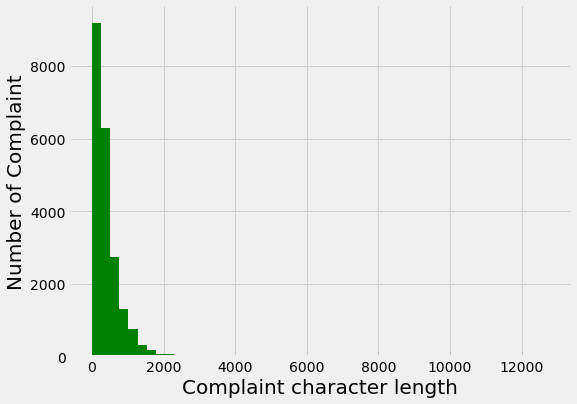

In [41]:
# Plot the data according to character length of complaints
plt.figure(figsize=(8,6))
plt.hist(doc_lens,bins= 50,color='green')
plt.ylabel('Number of Complaint', fontsize=20)
plt.xlabel('Complaint character length', fontsize=20)
sns.despine()
plt.show()

###  The distribution of word counts is skewed a little positie but overall it is a pretty mormal distribution.
###  Now, we plot the top 40 words by frequency using a word cloud

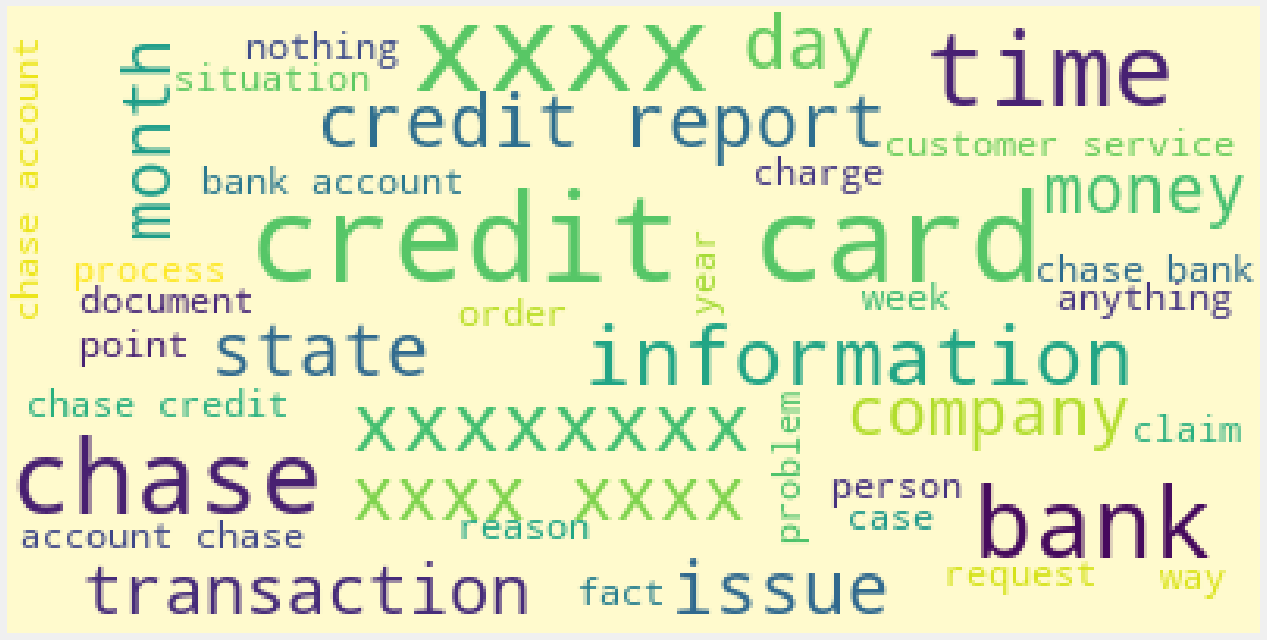

In [42]:
#Plot the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [43]:
#Removing -PRON- from the text corpus
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

###  We will remove the masked text as this will be of no use for our analysis.

In [44]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [45]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the

## Feature Extraction

In [46]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [47]:
# Create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling 

In [50]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

dictionary = Dictionary(dataset)

dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))


coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling

In [51]:
# Load nmf_model with the n_components set to 5
nmf_model = NMF(n_components=5, random_state=40)

In [52]:
# Fit the model on document term matrix
nmf_model.fit(dtm)


len(tfidf.get_feature_names())

7254

In [53]:
# Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

number
day
branch
deposit
chase
fund
money
check
bank
account


In [54]:
# Print the Top 15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [55]:
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [56]:
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_results.argmax(axis=1)
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my informa

In [57]:
df_clean5 = df_clean.groupby('Topic').head(5)

df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have pe

In [58]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}


df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [59]:
# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be a

## Model Building 

In [60]:
# Create the dictionary again of Topic names and Topic numbers
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my informa

In [61]:
training_data = df_clean[["complaint_what_happened","Topic"]]

training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [62]:
training_data.shape

(21072, 2)

In [63]:
training_data['Topic'].value_counts()

0    5241
1    5002
3    4762
4    3806
2    2261
Name: Topic, dtype: int64

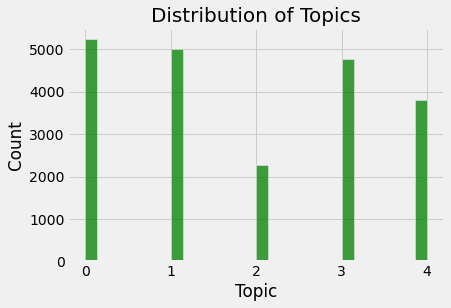

In [65]:
# Plot a histogram of classes (i.e. topics)
sns.histplot(data=training_data, x='Topic',color='green')
plt.title("Distribution of Topics", fontsize=20)
plt.show()



- As the distribution of target variable is not normal and there is imbalance of classes, we select **F1 Score** as our evaluation metric for comparing the performance of various models we will build.
- Moreover, we will use a **weighted average** method for evaluating `F1 Score` due to the imbalance of classes

In [66]:
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])


In [67]:

pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [68]:

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [69]:

pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [70]:

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33599)
Shape of y_test: (5268,)


In [71]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
   
    
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

## Naive Bayes 

In [72]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
%time 
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [73]:
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.6789353743140754

In [74]:
# Hyperparameter tuning to improve Naive Bayes performance
param_grid_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=clf_nb, 
                       param_grid=param_grid_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


{'alpha': 0.1, 'fit_prior': False}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished


In [75]:
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.1 µs


In [76]:
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.7830013573649698

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1324
Credit card or prepaid card       0.80      0.76      0.78      1279
                     Others       0.69      0.63      0.66       556
    Theft/Dispute Reporting       0.78      0.78      0.78      1196
              Mortgage/Loan       0.83      0.85      0.84       913

                   accuracy                           0.78      5268
                  macro avg       0.78      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



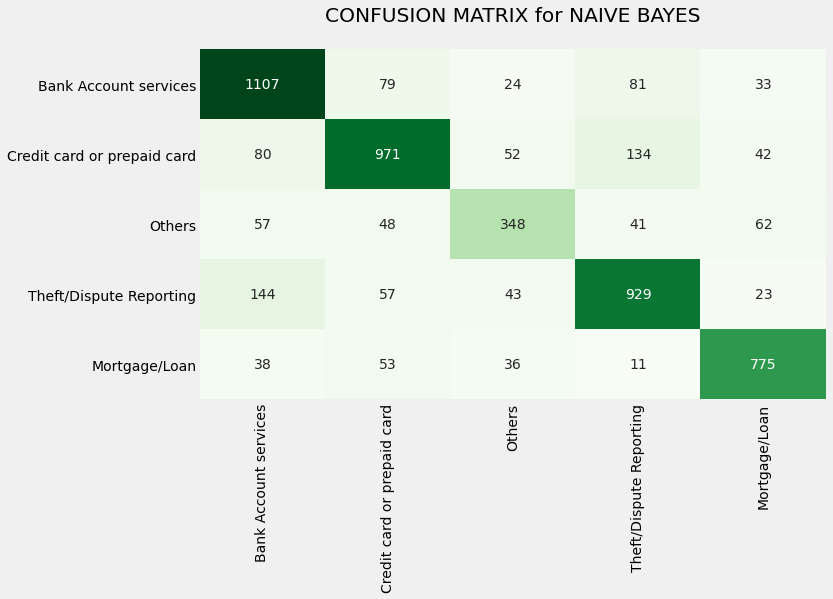

In [77]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

In [78]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score (untuned)': round(f1_nb, 2), 'F1 Score (tuned)': round(f1_nb_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.78


## Logistic Regression 

In [79]:
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15.7 µs


In [80]:
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9201842825422225

In [81]:
# Hyperparameter tuning to improve Logistic Regression performance
param_grid_lr = {
    'penalty': ['l1', 'l2','elasticnet', 'none'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=clf_lr, 
                       param_grid=param_grid_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.8min finished


{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [82]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [83]:
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9441013734310721

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1324
Credit card or prepaid card       0.95      0.96      0.95      1279
                     Others       0.93      0.96      0.94       556
    Theft/Dispute Reporting       0.94      0.91      0.93      1196
              Mortgage/Loan       0.94      0.94      0.94       913

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



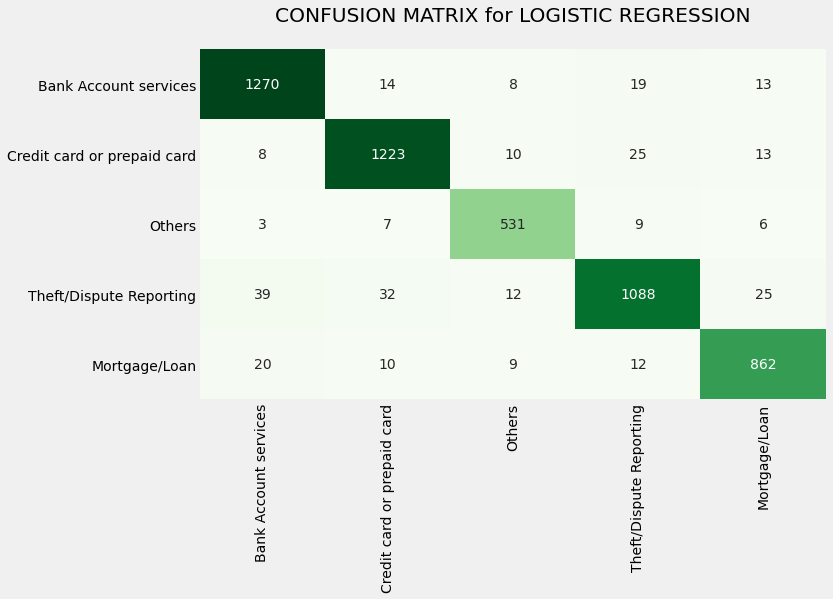

In [84]:
# Evaluate the tuned Logistic Regression classifier
eval_model(y_test, y_pred_lr_tuned, model_name)

In [85]:
# Update the summary table
summary.loc[len(summary.index)] = ['Logistic Regression', round(f1_lr, 2), round(f1_lr_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.94


## Random Forest 

In [86]:
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [87]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.8077426721992428

In [89]:
# Hyperparameter tuning to improve Random Forest performance
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion':['gini'],
    'max_depth': [10, 30, 40],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 5, 10], 
}

grid_rf = RandomizedSearchCV(estimator=clf_rf, 
                       param_distributions=param_grid_rf,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1,
                       cv=5)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'entropy'}


In [92]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)

clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

In [93]:
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8462734454659395

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.85      0.87      0.86      1324
Credit card or prepaid card       0.86      0.88      0.87      1279
                     Others       0.82      0.82      0.82       556
    Theft/Dispute Reporting       0.83      0.78      0.81      1196
              Mortgage/Loan       0.85      0.87      0.86       913

                   accuracy                           0.85      5268
                  macro avg       0.84      0.84      0.84      5268
               weighted avg       0.85      0.85      0.85      5268



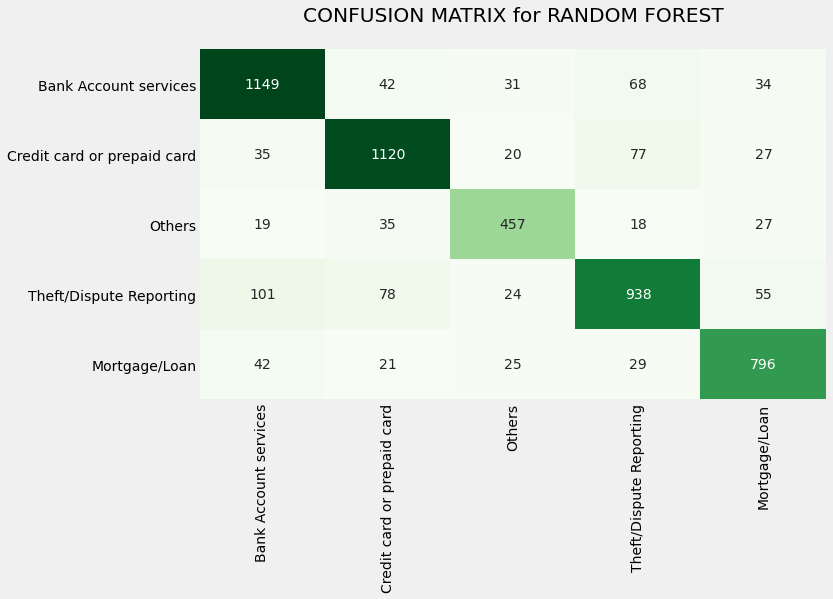

In [94]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

In [95]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.78
1,Logistic Regression,0.92,0.94
2,Random Forest,0.81,0.85


From the above summary table, we observe that the tuned Logistic Regression performs the best among all that we tried.

## Model Inference 

In [96]:
# Save tuned Logistic Regression model as pickle file
pickle.dump(clf_lr_tuned, open("logreg_model.pkl", "wb"))

In [97]:
def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [98]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from Morgan Stanley who services my mortgage, who owns it and who has original loan docs", 
                                  "The amount of my credit card was debited twice. Please look into the matter and resolve as soon as possiblr.",
                                  "I want to open an account at your new branch. Please help me with the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "How to know my FICO score?",
                                  "I need to know the number of bank branches and their locations in the city of Delhi"]})
df_new

,complaints
0,"I can not get from Morgan Stanley who services my mortgage, who owns it and who has original loan docs"
1,The amount of my credit card was debited twice. Please look into the matter and resolve as soon as possiblr.
2,I want to open an account at your new branch. Please help me with the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,How to know my FICO score?
5,I need to know the number of bank branches and their locations in the city of Delhi


In [99]:
# Final Predictions
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,"I can not get from Morgan Stanley who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The amount of my credit card was debited twice. Please look into the matter and resolve as soon as possiblr.,Credit card or prepaid card
2,I want to open an account at your new branch. Please help me with the procedure.,Bank Account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,How to know my FICO score?,Mortgage/Loan
5,I need to know the number of bank branches and their locations in the city of Delhi,Bank Account services
